## https://www.datasciencecapstone.org/competitions/10/appliances-energy-use/submissions/

In [1]:
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Input
from keras.layers import Conv2D, MaxPooling2D
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import GlobalAveragePooling2D
import matplotlib.pyplot as plt
import cv2
from keras import regularizers
import os
import pandas as pd
import glob
import numpy as np
import time
from sklearn.model_selection import train_test_split

ModuleNotFoundError: No module named 'keras'

## Operation system

In [2]:
import warnings

warnings.filterwarnings('ignore')
from tensorflow.python.client import device_lib
import tensorflow as tf
import keras
!python3 --version
print(device_lib.list_local_devices()[1])
print('tensorflow version: ',tf.__version__)
print('keras version: ',keras.__version__)

Python 3.6.6
name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 10911298356
locality {
  bus_id: 1
  links {
  }
}
incarnation: 15740712918324219643
physical_device_desc: "device: 0, name: GeForce GTX 1080 Ti, pci bus id: 0000:07:00.0, compute capability: 6.1"

tensorflow version:  1.10.0
keras version:  2.2.2


# Information of class

In [3]:
from sklearn.utils import shuffle

file_name = 'train_labels.csv'
whereami_img = pd.read_csv(file_name)
seed = int(time.time())
whereami_img = shuffle(whereami_img, random_state=seed)
print(whereami_img.head())
print(whereami_img.tail())
#print(whereami_img.id.value_counts())
classlst = os.listdir('train/')

batch_size = 8

       id  appliance
479  1479          2
553  1553         10
20   1020          0
527  1527          8
535  1535          0
       id  appliance
860  1860          6
622  1622          8
708  1708          1
690  1690          2
885  1885          2


In [4]:
listx= pd.DataFrame(whereami_img['id'])
listy= pd.DataFrame(whereami_img['appliance'])
print(listx.head())
print(listy.head())

       id
479  1479
553  1553
20   1020
527  1527
535  1535
     appliance
479          2
553         10
20           0
527          8
535          0


In [1]:
#from librosa.decompose import decompose
n_size= img_size = 139
re_size=(img_size,img_size)
x_train = []
y_train1 = []
x_valid = []
y_valid = []
for f in listx['id']:
    filename = './/train//'+str(f)+'_c.png'
    #print(f)
    if os.path.isfile(filename):
        img = cv2.imread(filename)
        #img = io.imread(filename, as_gray=True)
        #librosa.core.db_to_power
        img = cv2.resize(img, (img_size, img_size))
        img = img.astype(np.float32)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = img - np.array([123.68, 116.779, 103.939])
        #img = img[:,:,::-1]  # RGB to BGR
        img = (img - np.min(img)) / np.max(img)
        x_train.append(np.asarray(img))
        #print(type(x_train))
    else:
        print ("The file " + filename + " does not exist.")

num_classes=11
        
for f in listy['appliance']:
    y_train1.append(f)
    #print(y_train)
y_train=keras.utils.to_categorical(y_train1, num_classes)
print(y_train.shape)
plt.imshow(x_train[0])

NameError: name 'listx' is not defined

In [8]:
print(type(x_train))
x_train = np.array(x_train, dtype=np.float32)
print(type(x_train))

<class 'list'>
<class 'numpy.ndarray'>


In [9]:
print(y_train.shape)


(988, 11)


In [10]:
print(len(y_train))
print(len(x_train))
x_train1, x_valid1, y_train1 , y_valid1 = train_test_split(x_train, y_train,test_size=0.1,random_state=2)


988
988


## define image generator

In [12]:
def keras_train_normolize(x_input,x_test_input):
    x_input = x_input.astype('float32')
    x_test_input = x_test_input.astype('float32')
    #x_input /= 255.
    x_test_input /= 255.
    return x_input, x_test_input


In [13]:
from tqdm import tqdm_notebook #用來顯示進度條的套件
from sklearn.metrics import accuracy_score



#update_per_epoch = 100 #一個epoch要跑幾個batch
'''因為我們現在是用generator產生新的batch，所以我們要自行給定一個epoch要跑幾個batch,
當然也可以另外修改程式讓generator回傳適合的batch數(total number of data/batch size)'''


x_train, y_train = keras_train_normolize(x_train1, y_train1)
x_valid, y_valid = keras_train_normolize(x_valid1, y_valid1)
#x_train = x_train[train_index].reshape(-1,790)
print(x_train.shape)
print(y_train.shape)

(889, 139, 139, 3)
(889, 11)


In [15]:
from keras.applications.inception_v3 import InceptionV3


def InceptionV3_model():
    #base_model = NASNetMobile(input_shape= (n_size, n_size, 3),weights=None, include_top=False)
    base_model = InceptionV3(input_shape= (n_size, n_size, 3), include_top=False)
    #x= base_model.load_weights('./saved_models/NASNet-large-no-top.h5', by_name=True)
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    
    #x = BatchNormalization()(x)
    x= Dropout(0.5)(x)
    
    predictions = Dense(11, activation='softmax')(x)

# this is the model we will train
    return Model(inputs=base_model.input, outputs=predictions)

model= InceptionV3_model()


In [17]:
print('Using real-time data augmentation.')

datagen = ImageDataGenerator(
#     featurewise_center=True,
#     samplewise_center=True,
#     featurewise_std_normalization=True,
#     samplewise_std_normalization=True,
    #fill_mode='constant',
    rotation_range=0.01,
    width_shift_range=0.001,
    height_shift_range=0.001,
#    horizontal_flip=True,
#     vertical_flip=False,
#    rescale= 1./255
    #zca_whtening = True
    )

datagen.fit(x_train)

Using real-time data augmentation.


In [18]:
# Use ModelCheckpoint to save model and weights
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'keras_whereami_trained_model_c.h5'


if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
    
model_path = os.path.join(save_dir, model_name)

checkpoint = ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True, verbose=1)

model_train = 0


In [19]:
# earlystop
earlystop = EarlyStopping(monitor='val_loss', patience=15, verbose=1)

model_train = model#Xception_transfer#ResNetV2#NASNetL#ResNetV2#inceptv4#DenseNet_201 #model_inv3 #model_inv3

epochs=100

def train_model(Model_train, X_train, Y_train, X_test, Y_test, Checkpoint,Earlystop):
    #with tf.device('/device:GPU:1'):
    model_history = Model_train.fit_generator(datagen.flow(X_train, Y_train,
                                 batch_size=batch_size),
                    epochs=epochs,
                    #steps_per_epoch=20,
                    #class_weight = 'auto',
                    shuffle=True,                          
                    validation_data=(X_test, Y_test),
                    workers=4,
                    callbacks=[Checkpoint, Earlystop])
                    #callbacks=[Earlystop])
    
    return model_history, Model_train  


if(os.path.isfile(model_path1)):
    model_train.load_weights('./saved_models/keras_whereami_trained_model1.h5')
    print ("Load weight of keras_whereami_trained_model1.h5 ok")
    

#lr = 0.01*(batch_size/256) #0.000125
#lr = 0.0001
lr = 0.01
#opt = keras.optimizers.Adam(lr, beta_1=0.9, beta_2=0.999, epsilon=0.1,decay=0.001)
opt = keras.optimizers.Adam(lr, beta_1=0.9, beta_2=0.999, epsilon=0.1,decay=0.00001)

model_train.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])


tStart = time.time()#計時開始

model_history, model_train_final=train_model(model_train, x_train,y_train,x_valid,y_valid,checkpoint,earlystop)

tEnd = time.time()#計時結束  

print ("The final step cost %f sec" % (tEnd - tStart))

Load weight of keras_whereami_trained_model1.h5 ok
Epoch 1/100
112/112 [==============================] - 24s 215ms/step - loss: 0.0051 - acc: 0.6016 - val_loss: 0.0039 - val_acc: 0.7677

Epoch 00001: val_loss improved from inf to 0.00394, saving model to /home/jovyan/edx/saved_models/keras_whereami_trained_model.h5
Epoch 2/100
112/112 [==============================] - 11s 102ms/step - loss: 0.0050 - acc: 0.6061 - val_loss: 0.0040 - val_acc: 0.7677

Epoch 00002: val_loss did not improve from 0.00394
Epoch 3/100
112/112 [==============================] - 11s 102ms/step - loss: 0.0051 - acc: 0.6038 - val_loss: 0.0039 - val_acc: 0.7576

Epoch 00003: val_loss did not improve from 0.00394
Epoch 4/100
112/112 [==============================] - 11s 100ms/step - loss: 0.0051 - acc: 0.5893 - val_loss: 0.0040 - val_acc: 0.7576

Epoch 00004: val_loss did not improve from 0.00394
Epoch 5/100
112/112 [==============================] - 11s 100ms/step - loss: 0.0050 - acc: 0.6239 - val_loss: 0.0039 

## Load model to eva

In [21]:
# loading our save model
print("Loading trained model")
model = load_model(model_path)

# Score trained model.
scores = model.evaluate(x_valid, y_valid, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

Loading trained model
99/99 [==============================] - 2s 21ms/step
Test loss: 0.00310857092663
Test accuracy: 0.808080808081


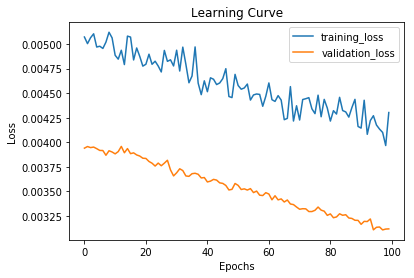

In [22]:
if(model_train!=0):
    training_loss = model_history.history['loss']
    val_loss = model_history.history['val_loss']

    plt.plot(training_loss, label="training_loss")
    plt.plot(val_loss, label="validation_loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Learning Curve")
    plt.legend(loc='best')
    plt.show()

## Start to get result from testset

In [30]:
import ntpath


def path_leaf(path):
    head, tail = ntpath.split(path)
    return tail or ntpath.basename(head)

test_path = os.path.join(os.getcwd(), 'test')
test_list = glob.glob(os.path.join(test_path, '*_c.png'))
test_id = [path_leaf(s).strip('_c.png') for s in test_list]
print(len(test_id))
test_list1 = glob.glob(os.path.join(test_path, '*_v.png'))
test_id1 = [path_leaf(s).strip('_v.png') for s in test_list1]
print(len(test_id1))

659
659


In [65]:
test_data_list =[]
re_size =(139,139)

for i in range(len(test_list)):
#     img = cv2.imread(test_list[i])
#     img = cv2.resize(img,re_size)
#     img = img.astype(np.float32)
#     img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#     img = img - np.array([123.68, 116.779, 103.939])
    img = cv2.imread(test_list[i])
    img = cv2.resize(img, (img_size, img_size))
    img = img.astype(np.float32)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img - np.array([123.68, 116.779, 103.939])
    #img = img[:,:,::-1]  # RGB to BGR
    img = (img - np.min(img)) / np.max(img)
   
    test_data_list.append(img)
    
test_data = np.array(test_data_list)    
#test_data = test_data.astype('float32')
#test_data /= 255
print(test_data.shape)

(659, 139, 139, 3)


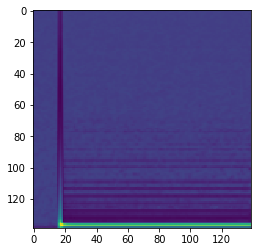

In [66]:
plt.imshow(test_data[0][:,:,0])
plt.show()   

In [67]:
y_pred = model.predict(test_data)
y_pred = np.argmax(y_pred, axis=1)
y_pred

array([ 7,  5,  2,  4,  8,  5,  8,  0,  7,  2,  7,  2,  0,  8,  5,  0,  1,
        8,  4,  2,  2,  3,  3,  3,  3,  5,  5,  6,  2, 10,  1,  6,  3,  3,
        2,  0,  1,  6,  6,  8, 10,  4,  0,  8,  2,  1,  7,  0,  0,  1,  8,
        8,  2,  8,  8,  4,  7,  8,  8,  3,  3,  0,  5,  2,  2,  8,  1,  0,
       10,  6,  1,  5,  1,  2,  6,  5,  5,  5,  2,  1,  2,  0,  1,  3,  3,
        5,  7,  5,  2,  5,  3,  8,  5,  1,  8,  7,  5,  4,  3,  8,  1,  3,
        1,  7,  2,  2,  9,  2,  7,  4,  7,  0,  5,  0,  5,  8,  3,  4,  7,
        6,  8,  2,  3,  5,  1,  3,  2,  1,  8,  0,  0,  4,  8,  8,  2,  1,
        5,  2,  3,  1,  3,  1,  1,  0,  2,  4,  7,  3,  1,  3,  8,  3,  1,
        2,  7, 10,  0,  8,  8,  3, 10,  0,  5,  3,  3,  0,  8,  7,  1,  7,
       10,  1,  1,  2,  2,  7,  0,  5,  1,  5,  6,  4,  7,  0,  7,  8,  8,
        8,  4,  0,  1,  6,  3, 10, 10,  8,  8,  9,  0,  8,  3,  8,  3,  1,
        1,  9,  1,  5,  3,  4,  1,  8,  0,  7,  6,  2,  2,  8,  2,  5,  0,
        2,  2,  1,  2,  1

In [68]:
print(len(y_pred))

659


In [71]:
df = pd.DataFrame( {"id": test_id, "appliance": pd.Series(y_pred)} )
df = df[['id', 'appliance']]
df=df.sort_values (["id"])
#df=df.sort_values (["id"],ascending=True)
df.to_csv('submission_data_c.csv', index = False)

In [72]:
df.head(20)

,id,appliance
233,1988,8
635,1989,1
104,1990,2
99,1991,8
137,1992,2
538,1993,5
196,1994,8
163,1995,3
610,1996,2
245,1997,0
